### before we start we need to sset some expectations:
T-test is a parametric test; it expects the data to be normaly distibuted. Bulk RNA count data mostly follow the negative binormial distribution, which will have a great impact on the final results as a false positive. However, there are some tools that did modified t-test on bulk RNA data as well as microarray expression data like lima.
we are going to work on the Bulk RNA expression data, 
to overcome the limitation of the t-test in DEA we need to be carefull of the distribution, variance and mean of the data before we run any test

In [2]:
print('بسم الله الرحمن الرحيم')

بسم الله الرحمن الرحيم


In [71]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
# reading the data 
expr_df = pd.read_csv("TCGA_BRCA_counts.tsv", sep="\t", index_col=0) # Expression data
meta_df = pd.read_csv("TCGA_BRCA_metadata.tsv", sep="\t") # metadata
meta_df.set_index('barcode', inplace =True)
any(expr_df.columns==expr_df.columns) #making sure that the samples ID match

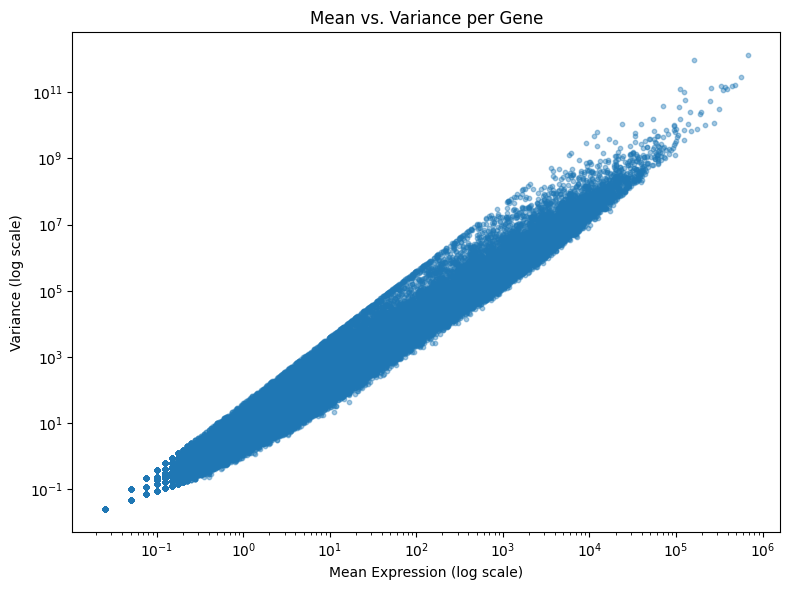

In [43]:
# Calculate mean and variance for each gene
gene_means = expr_df.mean(axis=1)
gene_vars = expr_df.var(axis=1)

# Plot variance X mean to test scedasticity
plt.figure(figsize=(8,6))
plt.scatter(gene_means, gene_vars, alpha=0.4, s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Mean Expression (log scale)")
plt.ylabel("Variance (log scale)")
plt.title("Mean vs. Variance per Gene")
plt.tight_layout()
plt.show()

variance increases with mean; data is heteroscedastic, Negative Binomial most likely

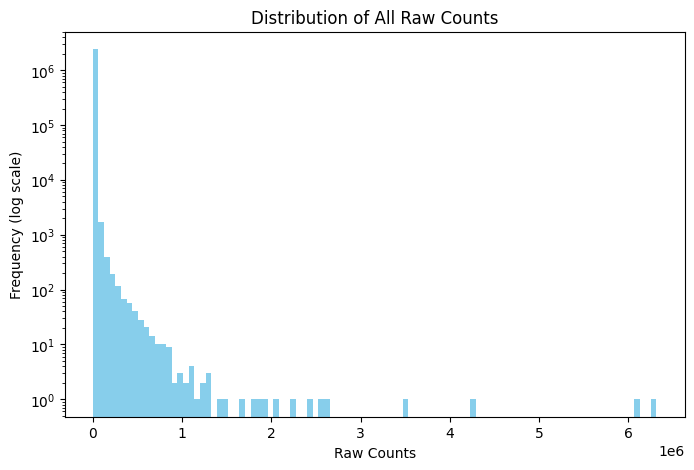

In [46]:
#histogram plot
all_counts = expr_df.values.flatten()

plt.figure(figsize=(8,5))
plt.hist(all_counts, bins=100, color='skyblue')
plt.yscale('log')
plt.xlabel("Raw Counts")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of All Raw Counts")
plt.show()


data is skewed, normal in bulk RNA

In [81]:
from scipy.stats import chi2
import numpy as np
import pandas as pd

# Function to test for overdispersion in count data
def test_overdispersion(counts):
    # Compute sample mean of gene expression counts
    mean_ = np.mean(counts)
    
    # Compute sample variance (ddof=1 for unbiased estimator)
    var_ = np.var(counts, ddof=1)
    
    # Compute the test statistic for overdispersion
    # Under the Poisson assumption, mean == variance
    # This formula tests how far the observed variance deviates from the mean
    dispersion_stat = ((var_ - mean_) ** 2) / ((2 / (len(counts) - 1)) * mean_ ** 2)
    
    # Calculate p-value from chi-squared distribution (df = 1)
    # Small p-value => variance significantly different from mean => overdispersion => Negative Binomial
    p_value = 1 - chi2.cdf(dispersion_stat, df=1)
    
    return p_value, var_, mean_

results = []

for gene in expr_df.index:
    gene_counts = expr_df.loc[gene]  # Get expression values across samples for one gene
    pval, var_, mean_ = test_overdispersion(gene_counts)  
    results.append((gene, mean_, var_, pval))  # Store gene-level results

# Convert the list of tuples to a pandas DataFrame for analysis and plotting
df_test = pd.DataFrame(results, columns=["gene", "mean", "var", "pval"])

/tmp/ipykernel_35/2883337988.py:8: RuntimeWarning: invalid value encountered in scalar divide
  dispersion_stat = ((var_ - mean_) ** 2) / ((2 / (len(counts) - 1)) * mean_ ** 2)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2132: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


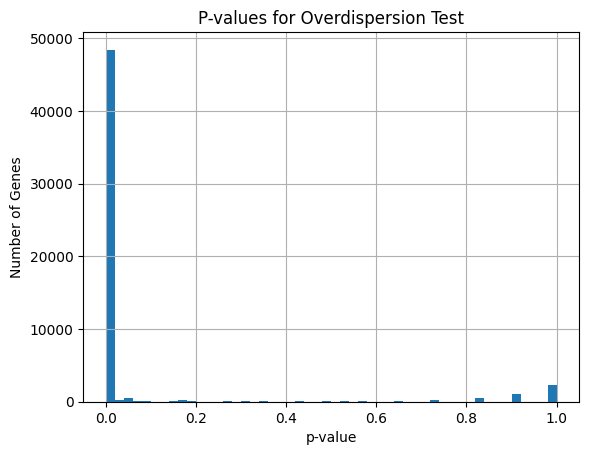

In [82]:
# Histogram of p-values
df_test["pval"].hist(bins=50)
plt.title("P-values for Overdispersion Test")
plt.xlabel("p-value")
plt.ylabel("Number of Genes")
plt.show()

most genes's P-calue are less than 0.5 which mean that there follow negative binormal distribution

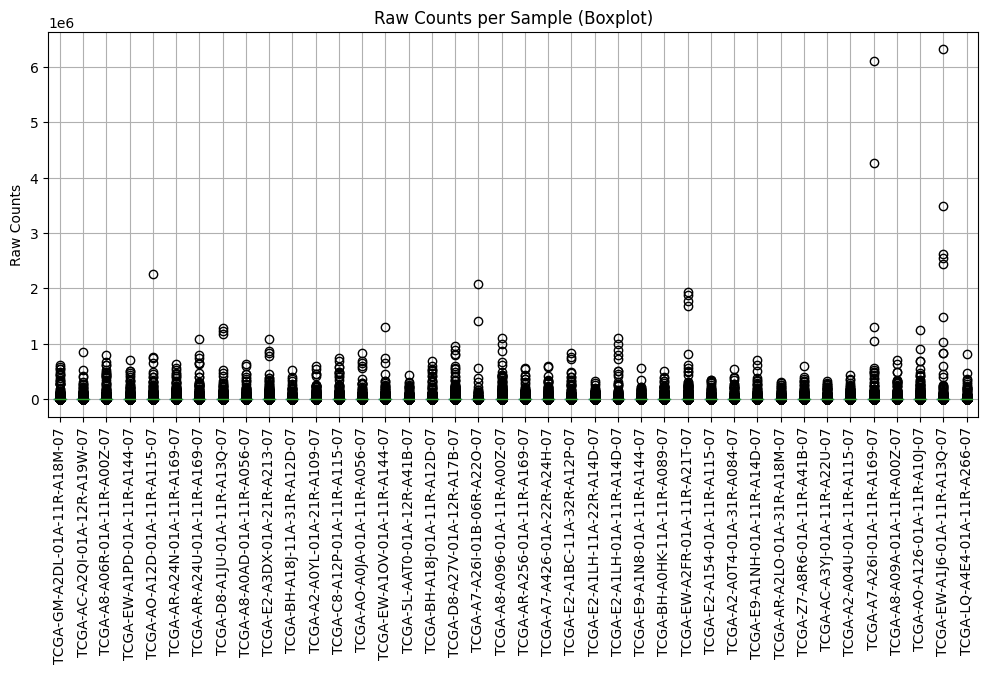

In [54]:
# boxplot of each sample To detect library size differences or outliers across samples.
plt.figure(figsize=(12,5))
expr_df.boxplot()
plt.xticks(rotation=90)
plt.ylabel("Raw Counts")
plt.title("Raw Counts per Sample (Boxplot)")
plt.show()

too amny outlies which is normal in bulk RNA seq we need to normalize the data 


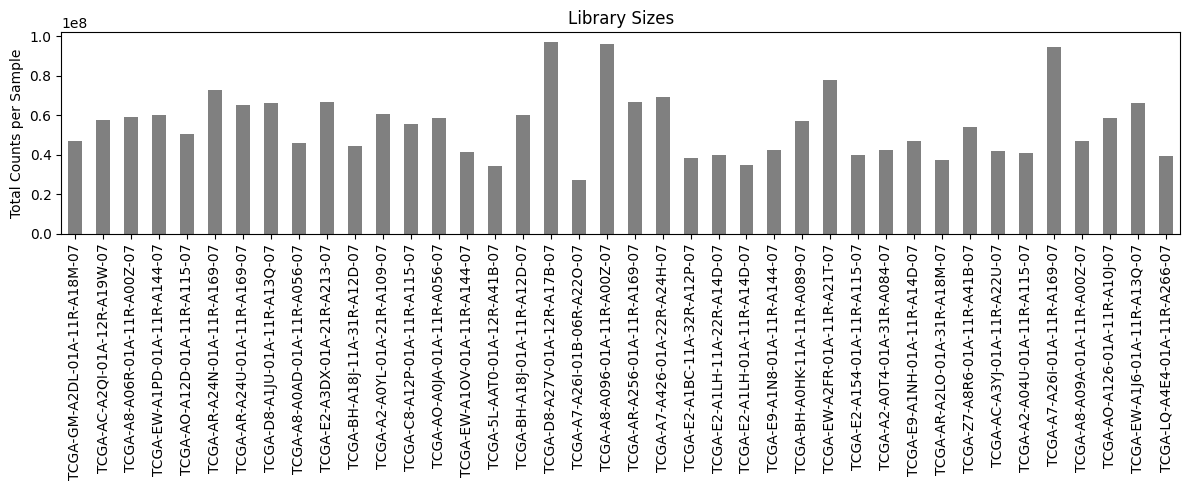

In [68]:
# library size of each sample to identify whether samples need scaling normalization
library_sizes = expr_df.sum()

plt.figure(figsize=(12,5))
library_sizes.plot(kind='bar', color='gray')
plt.ylabel("Total Counts per Sample")
plt.title("Library Sizes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


there are huge difference in library size of each, data need to be scaled (for better PCA as well )

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

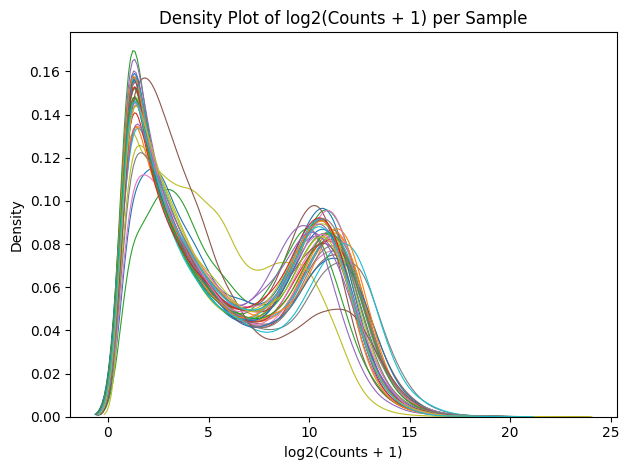

In [74]:
for col in expr_df.columns:
    values = expr_df[col]
    values = values[values > 0]  # skip 0s
    log_vals = np.log2(values + 1)
    sns.kdeplot(log_vals, label=col, linewidth=0.8)

plt.title("Density Plot of log2(Counts + 1) per Sample")
plt.xlabel("log2(Counts + 1)")
plt.ylabel("Density")
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

the log2(value +1) did well in all the sample, log2 transformation is best suitable for all the samples

in case of normalization we will follow the DESeq2's size factor normalization as each sample differ in its library size and each gene differ as well

breif explanation of each sample used in DESeq2’s Size Factor Normalization:

1. For each gene, compute the geometric mean across all samples.

2. For each sample, divide the count for each gene by the gene’s geometric mean.

3. The median of these ratios for each sample is the size factor.

4. Normalize counts by dividing each column (sample) by its size factor.

In [90]:
def size_factor_normalization(counts):
    # skipping gene that are zero 
    counts = counts[(counts > 0).sum(axis=1) > 0]

    # Function to compute geometric mean (ignoring zeros)
    def geometric_mean(x):
        return np.exp(np.log(x[x > 0]).mean()) if np.any(x > 0) else np.nan
    
    # 1. Apply to each gene
    geo_means = counts.apply(geometric_mean, axis=1)
    
    # 2. Divide each count by the geometric mean of the gene
    ratios = counts.div(geo_means, axis=0)
    
    # 3. Compute median of ratios per sample 
    size_factors = ratios.median(axis=0)
    
    # 4. Divide each sample by its size factor
    norm_counts = counts.div(size_factors, axis=1)
    return norm_counts

In [93]:
# doing the transformaation and normalization 
norm_counts = size_factor_normalization(expr_df) # normalizing counts

log_norm_counts = np.log2(norm_counts + 1) 

In [101]:
# before we do log2 transformation we need to remove genes that are lwoely expressed in less than 10 samples out of 40 (25%)
min_samples = int(norm_counts.shape[1] * 0.25) 
norm_filtered = norm_counts[(norm_counts > 10).sum(axis=1) >= min_samples]

# Apply log2 again
log_norm_filtered = np.log2(filtered + 1) #log2 transform

Text(0.5, 1.0, 'Boxplot After preprocessing (Size Factor Normalization + Log2')

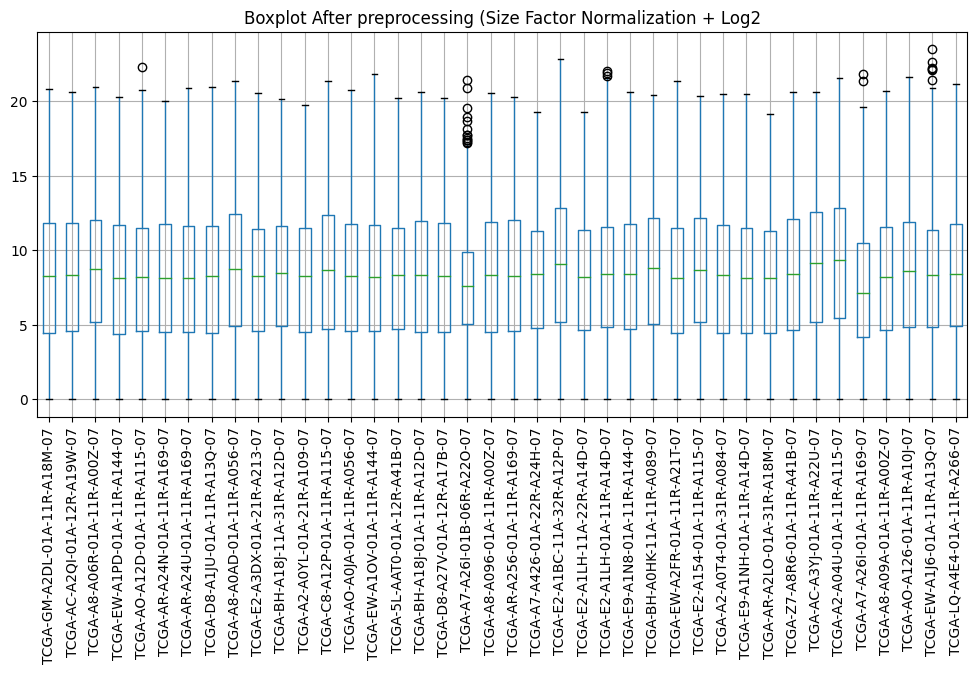

In [104]:
# box plot after the pre-processing step 
log_norm_filtered.boxplot(rot=90, figsize=(12,5))
plt.title("Boxplot After preprocessing (Size Factor Normalization + Log2")

# data is now ready for futher analysis 

In [106]:
log_norm_filtered.to_csv('Processed_TCGA_BRCA_counts.tsv', sep= '\t')

In [126]:
# doing PCA to test sample metadata on the expression 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


X = log_norm_filtered.T.values # Transpose: samples as rows
X_scaled = StandardScaler().fit_transform(X) #PCA needs the data to be scaled

pca = PCA(n_components=10)
pc = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pc[0, index=log_norm_filtered.columns)  # sample IDs as index for each pc

pca_annotated = pd.concat([pca_df, meta_df], axis=1) # combine the metadata wit PCs


In [230]:
#function for ploting PCA
def plot_PCA(data, column):
    sns.scatterplot(data=data, x=0, y=1, hue=column)
    plt.title(f"PCA Colored by {column}")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)") # to add the variance explained precentage in the label
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    plt.legend(title=column)
    plt.tight_layout()
    plt.show()

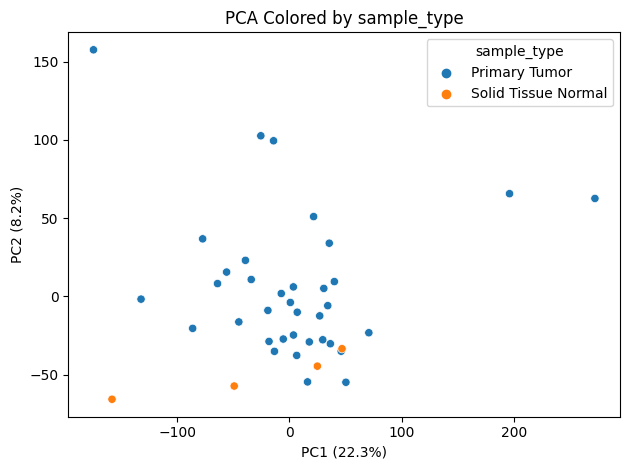

In [231]:
plot_PCA(pca_annotated, 'sample_type')

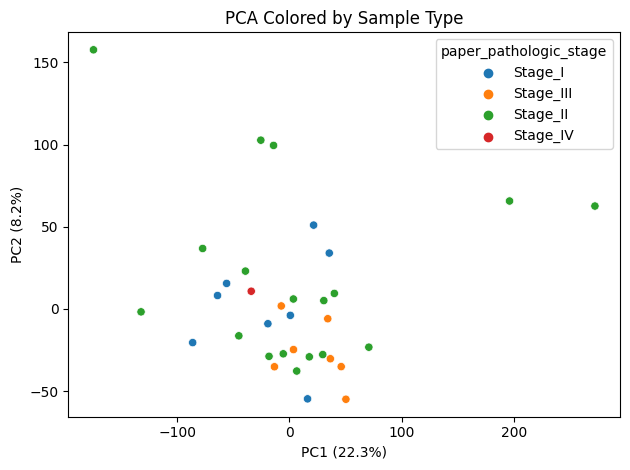

In [225]:
plot_PCA(pca_annotated, 'paper_pathologic_stage')

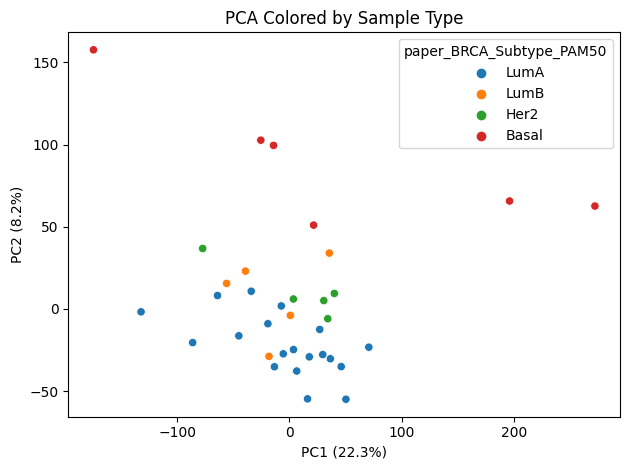

In [221]:
plot_PCA(pca_annotated, 'paper_BRCA_Subtype_PAM50')

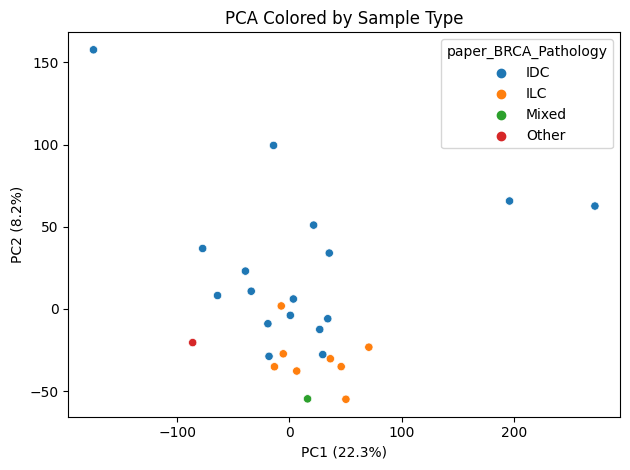

In [190]:
plot_PCA(pca_annotated, 'paper_BRCA_Pathology')

from the previous PCA plot we can see that the basal (TNBC) is the most hetergenous from all the sample, while the rest of the samples (lum A, lum B, her2+) have similar molecular patterns as they differ in expression of certain biomarker (ER, PR, Her2), on the other hand the basal lack the expression of all of those markers

In [237]:
meta_df[meta_df['paper_BRCA_Subtype_PAM50']!= 'Basal'].index

Index(['TCGA-GM-A2DL-01A-11R-A18M-07', 'TCGA-AC-A2QI-01A-12R-A19W-07',
       'TCGA-A8-A06R-01A-11R-A00Z-07', 'TCGA-EW-A1PD-01A-11R-A144-07',
       'TCGA-AO-A12D-01A-11R-A115-07', 'TCGA-AR-A24N-01A-11R-A169-07',
       'TCGA-AR-A24U-01A-11R-A169-07', 'TCGA-D8-A1JU-01A-11R-A13Q-07',
       'TCGA-A8-A0AD-01A-11R-A056-07', 'TCGA-E2-A3DX-01A-21R-A213-07',
       'TCGA-BH-A18J-11A-31R-A12D-07', 'TCGA-A2-A0YL-01A-21R-A109-07',
       'TCGA-C8-A12P-01A-11R-A115-07', 'TCGA-AO-A0JA-01A-11R-A056-07',
       'TCGA-EW-A1OV-01A-11R-A144-07', 'TCGA-5L-AAT0-01A-12R-A41B-07',
       'TCGA-BH-A18J-01A-11R-A12D-07', 'TCGA-D8-A27V-01A-12R-A17B-07',
       'TCGA-A8-A096-01A-11R-A00Z-07', 'TCGA-A7-A426-01A-22R-A24H-07',
       'TCGA-E2-A1BC-11A-32R-A12P-07', 'TCGA-E2-A1LH-11A-22R-A14D-07',
       'TCGA-BH-A0HK-11A-11R-A089-07', 'TCGA-EW-A2FR-01A-11R-A21T-07',
       'TCGA-E2-A154-01A-11R-A115-07', 'TCGA-A2-A0T4-01A-31R-A084-07',
       'TCGA-E9-A1NH-01A-11R-A14D-07', 'TCGA-AR-A2LO-01A-31R-A18M-07',
      

In [244]:
# removing the basal subtypes from metadata
meta_df= meta_df[meta_df['paper_BRCA_Subtype_PAM50']!= 'Basal']

In [247]:
# removing the basal subtypes from expression data
log_norm_filtered= log_norm_filtered[meta_df.index] 

In [250]:
# extracting 'Primary Tumor' and 'Solid Tissue Normal' as cancer and control
sample_groups = meta_df['sample_type']
# Subset expression matrix to tumor and normal samples
tumor_samples = sample_groups[sample_groups == "Primary Tumor"].index # extracting the index so we can get the sample ID
normal_samples = sample_groups[sample_groups == "Solid Tissue Normal"].index

In [271]:
from scipy.stats import ttest_ind

def T_test(expression_data, T_samples_names, N_samples_names):

    results = []
    
    for gene in expression_data.index:
        tumor_vals = expression_data.loc[gene, T_samples_names]
        normal_vals = expression_data.loc[gene, N_samples_names]
        
        # T-test 
        stat, pval = ttest_ind(tumor_vals, normal_vals, equal_var=False) 
        # we used independant t-test cause the samples are from different patients 
        
        fc = tumor_vals.mean() - normal_vals.mean()  # since data is log2-transformed we can subtract directly
        
        # Change type if the FC larger than one "over-expressed", smaller "down-expressed"
        if fc > 1:
            change = "over-expressed"
        elif fc < -1:
            change = "down-expressed"
        else:
            change = "equally-expressed"
            
        results.append((gene, fc, pval, stat, change)) # adding the values
        
    df_results = pd.DataFrame(results, columns=["gene", "log2_fold_change", "p_value", "t_statistic", "change_type"])

        
    return df_results

## T-test


In [282]:
results_ttest = T_test(log_norm_filtered, tumor_samples, normal_samples)
results_ttest

,gene,log2_fold_change,p_value,t_statistic,change_type
0,ENSG00000000003.15,-1.066279,0.011700,-3.618441,down-expressed
1,ENSG00000000005.6,-4.615410,0.005989,-4.902981,down-expressed
2,ENSG00000000419.13,-0.103408,0.829569,-0.232983,equally-expressed
3,ENSG00000000457.14,0.142836,0.616167,0.534957,equally-expressed
4,ENSG00000000460.17,0.977819,0.000002,6.098857,equally-expressed
...,...,...,...,...,...
26461,ENSG00000288658.1,-0.001469,0.999182,-0.001100,equally-expressed
26462,ENSG00000288663.1,0.418936,0.149176,1.569086,equally-expressed
26463,ENSG00000288670.1,-0.211013,0.636521,-0.512780,equally-expressed
26464,ENSG00000288674.1,-1.410145,0.174485,-1.670278,down-expressed


In [281]:
results_ttest.to_csv('t_test_results.tsv', sep= '\t', index=False)

In [319]:
def Volcano_plot(data, log2fc_thresh=1, pval_thresh=0.05):
    """
    Generates a volcano plot for differential expression results.

    Parameters:
        data (DataFrame): Must contain 'log2_fold_change' and 'p_value' columns.
        log2fc_thresh (float): Threshold for absolute log2 fold change (default = 1).
        pval_thresh (float): P-value threshold for significance (default = 0.05).
    """
    # Compute -log10(p-value) for volcano plot (Y-axis)
    # Add a very small number (1e-10) to avoid taking log of zero, which would cause an error
    data["neg_log10_pval"] = -np.log10(data["p_value"] + 1e-10)
    
    
    # Function to classify each gene as Upregulated, Downregulated, or Not Significant
    def categorize(row):
        if row["p_value"] < pval_thresh:
            if row["log2_fold_change"] > log2fc_thresh:
                return "Up"                    # Significantly upregulated
            elif row["log2_fold_change"] < -log2fc_thresh:
                return "Down"                 # Significantly downregulated
        return "Not Significant"              # Doesn’t pass thresholds
    
    # Apply categorization to each gene
    data["category"] = data.apply(categorize, axis=1)
    
    # Initialize the plot
    plt.figure(figsize=(10, 6))
    
    # Create the volcano plot using seaborn
    sns.scatterplot(
        data=data,                            # DataFrame with test results
        x="log2_fold_change",                          # X-axis: log2 fold change
        y="neg_log10_pval",                            # Y-axis: –log10 p-value
        hue="category",                                # Color by DEG status
        palette={"Up": "red", "Down": "blue", "Not Significant": "gray"},
        alpha=0.6, linewidth=0                         
    )
    
    # Draw vertical threshold lines for fold change
    plt.axvline(x=log2fc_thresh, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=-log2fc_thresh, color='black', linestyle='--', linewidth=1)
    
    # Draw horizontal threshold line for p-value
    plt.axhline(y=-np.log10(pval_thresh), color='black', linestyle='--', linewidth=1)
    
    # plot labels
    plt.title("Volcano Plot of Differential Expression")
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("-Log10 P-value")
    plt.legend(title="DEG Status")
    plt.tight_layout()
    
    # Display the plot
    plt.show()

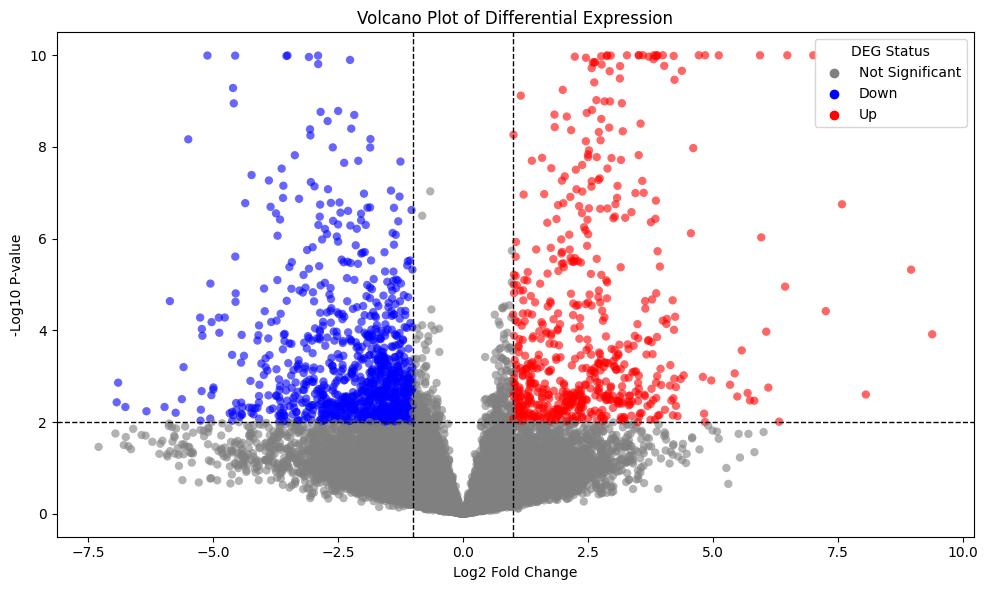

In [320]:
Volcano_plot(results_ttest, log2fc_thresh = 1, pval_thresh = 0.01)

the Wilcoxon test used ranks to find find the differentially expressed genes, which needs the data to be normalized but not log2 transformed 

In [296]:
norm_counts = norm_counts[meta_df.index] # subsetting the basal subtypes

Tumor: 30, Normal: 4


In [310]:
from scipy.stats import ranksums

def Wilcoxon_ranks_sum(expression_data, T_samples_names, N_samples_names):
    # also known as the Mann-Whitney U test (unpaired) 
    # we used this test specifically because the datasets are independant; different patients
    
    results = []
    
    for gene in expression_data.index:
        tumor_vals = expression_data.loc[gene, T_samples_names]
        normal_vals = expression_data.loc[gene, N_samples_names]
        
        # Wilcoxon rank-sum test 
        stat, pval = ranksums(tumor_vals, normal_vals)
    
        # Fold change: here we need to log2 transform the data to calculate the fc
        tumor_vals = np.log2(tumor_vals + 1)
        normal_vals = np.log2(normal_vals + 1)

        # Avoid division by zero
        fc = tumor_vals.mean() - normal_vals.mean()  # since we log2-transformed the data previously we can subtract directly

        # Change type if the FC larger than one "over-expressed", smaller "down-expressed"
        if fc > 1:
            change = "over-expressed"
        elif fc < -1:
            change = "down-expressed"
        else:
            change = "equally-expressed"
    
        results.append((gene, fc, pval, stat, change))
        
    df_results = pd.DataFrame(results, columns=["gene", "log2_fold_change", "p_value", "statistic", "change_type"])
    
    return df_results

In [311]:
results_Wilcoxon = Wilcoxon_ranks_sum(log_norm_filtered, tumor_samples, normal_samples)
results_Wilcoxon

,gene,log2_fold_change,p_value,statistic,change_type
0,ENSG00000000003.15,-0.113140,0.016157,-2.405351,equally-expressed
1,ENSG00000000005.6,-0.977982,0.003283,-2.939874,equally-expressed
2,ENSG00000000419.13,-0.010151,0.872600,0.160357,equally-expressed
3,ENSG00000000457.14,0.015154,0.521245,0.641427,equally-expressed
4,ENSG00000000460.17,0.129025,0.007526,2.672612,equally-expressed
...,...,...,...,...,...
26461,ENSG00000288658.1,0.113101,0.789268,-0.267261,equally-expressed
26462,ENSG00000288663.1,0.078479,0.422678,0.801784,equally-expressed
26463,ENSG00000288670.1,-0.029293,0.789268,-0.267261,equally-expressed
26464,ENSG00000288674.1,-0.521370,0.181449,-1.336306,equally-expressed


In [312]:
results_Wilcoxon.to_csv('Wilcoxon_results.tsv', sep= '\t', index=False)

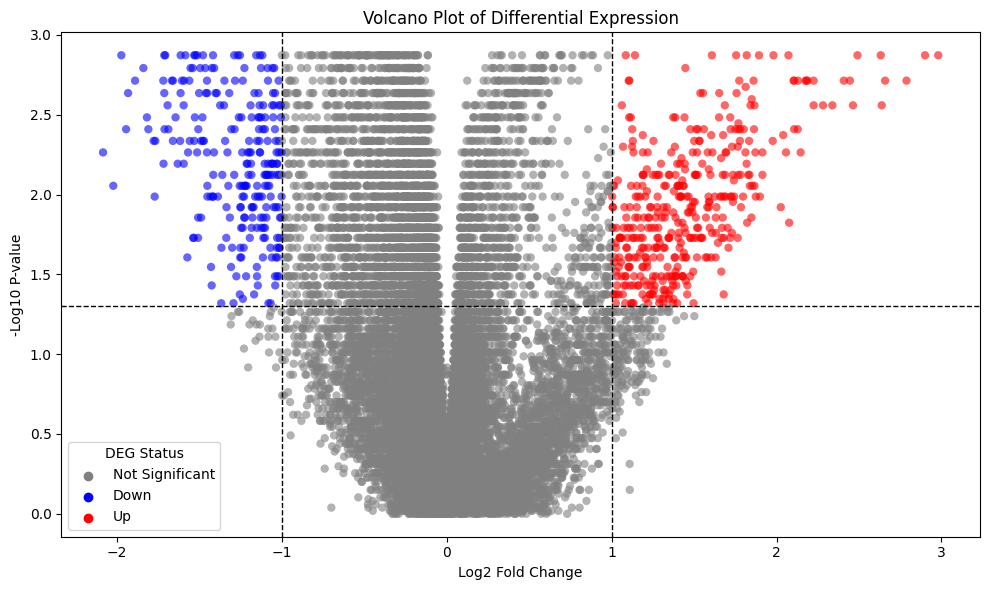

In [318]:
Volcano_plot(results_Wilcoxon)